In [ ]:
# %%
# Notebook 5: LLM-as-Judge Evaluation
# Run this AFTER notebook 3 to evaluate response quality

import sys
import os
sys.path.append('..')

# SET API KEY
OPEN_API_KEY = "your key goes here"
os.environ["OPENAI_API_KEY"] = OPEN_API_KEY

import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Dict, List
import logging
from tqdm import tqdm

from src.utils import evaluate_with_llm_judge

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

ROOT_DIR = Path('..').resolve()
RESULTS_DIR = ROOT_DIR / 'results'

print(f"Results directory: {RESULTS_DIR}")

# %%
# Load the most recent experiment results from notebook 3
csv_files = list(RESULTS_DIR.glob('hindi_healthcare_rag_*.csv'))

if not csv_files:
    print("❌ No experiment results found. Please run notebook 3 first.")
    raise FileNotFoundError("No experiment results found")

latest_file = max(csv_files, key=lambda x: x.stat().st_mtime)
print(f"Loading: {latest_file.name}")

df_results = pd.read_csv(latest_file, encoding='utf-8')
print(f"✓ Loaded {len(df_results)} experiment results")

# Check if we have the required columns
required_cols = [
    'question_hindi', 'question_english_reference',
    'multilingual_chunks', 'translation_chunks',
    'multilingual_response_hindi', 'translation_response_hindi',
    'multilingual_response_english_for_eval', 'translation_response_english_for_eval'
]

missing_cols = [col for col in required_cols if col not in df_results.columns]
if missing_cols:
    print(f"⚠️  Missing columns: {missing_cols}")
    print("   Please re-run notebook 3 with updated rag_system.py that saves chunks")
    raise ValueError("Missing required columns for LLM-as-judge evaluation")

print("✓ All required columns present")

# %%
# Run LLM-as-Judge Evaluation

print("\n" + "="*80)
print("RUNNING LLM-AS-JUDGE EVALUATION")
print("="*80)

evaluations = []

for idx, row in tqdm(df_results.iterrows(), total=len(df_results), desc="Evaluating"):
    question_hindi = row['question_hindi']
    question_english = row['question_english_reference']
    
    # Evaluate Multilingual Approach
    print(f"\n[{idx+1}/{len(df_results)}] Evaluating Multilingual approach for: {question_hindi[:50]}...")
    eval_multi = evaluate_with_llm_judge(
        question_hindi=question_hindi,
        question_english=question_english,
        reference_text=row['multilingual_chunks'],
        answer_hindi=row['multilingual_response_hindi'],
        answer_english=row['multilingual_response_english_for_eval'],
        approach="Multilingual Embeddings",
        model="gpt-4o"
    )
    
    # Evaluate Translation Approach
    print(f"    Evaluating Translation approach...")
    eval_trans = evaluate_with_llm_judge(
        question_hindi=question_hindi,
        question_english=question_english,
        reference_text=row['translation_chunks'],
        answer_hindi=row['translation_response_hindi'],
        answer_english=row['translation_response_english_for_eval'],
        approach="Translation Pipeline",
        model="gpt-4o"
    )
    
    if eval_multi and eval_trans:
        evaluations.append({
            'question_id': row['question_id'],
            'question_hindi': question_hindi,
            'question_english': question_english,
            
            # Multilingual scores
            'multi_faithfulness_label': eval_multi['faithfulness']['label'],
            'multi_faithfulness_score': eval_multi['faithfulness']['score'],
            'multi_completeness_label': eval_multi['completeness']['label'],
            'multi_completeness_score': eval_multi['completeness']['score'],
            'multi_appropriateness_label': eval_multi['medical_appropriateness']['label'],
            'multi_appropriateness_score': eval_multi['medical_appropriateness']['score'],
            'multi_overall': eval_multi['overall_assessment'],
            'multi_issues': str(eval_multi.get('key_issues', [])),
            
            # Translation scores
            'trans_faithfulness_label': eval_trans['faithfulness']['label'],
            'trans_faithfulness_score': eval_trans['faithfulness']['score'],
            'trans_completeness_label': eval_trans['completeness']['label'],
            'trans_completeness_score': eval_trans['completeness']['score'],
            'trans_appropriateness_label': eval_trans['medical_appropriateness']['label'],
            'trans_appropriateness_score': eval_trans['medical_appropriateness']['score'],
            'trans_overall': eval_trans['overall_assessment'],
            'trans_issues': str(eval_trans.get('key_issues', []))
        })
        
        print(f"    ✓ Multi: F={eval_multi['faithfulness']['score']}, C={eval_multi['completeness']['score']}, A={eval_multi['medical_appropriateness']['score']}")
        print(f"    ✓ Trans: F={eval_trans['faithfulness']['score']}, C={eval_trans['completeness']['score']}, A={eval_trans['medical_appropriateness']['score']}")
    else:
        print(f"    ⚠️  Evaluation failed for question {idx+1}")

df_llm_judge = pd.DataFrame(evaluations)

# Save results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = RESULTS_DIR / f'llm_judge_evaluation_{timestamp}.csv'
df_llm_judge.to_csv(output_file, index=False, encoding='utf-8')

print(f"\n✓ LLM-as-Judge evaluation complete!")
print(f"  Saved to: {output_file}")
print(f"  Evaluated: {len(df_llm_judge)} questions")

# %%
# Generate Summary Statistics

print("\n" + "="*80)
print("LLM-AS-JUDGE EVALUATION SUMMARY")
print("="*80)

# Faithfulness (Hallucination)
print("\n📊 FAITHFULNESS (Hallucination Detection):")
print("\nMultilingual Embeddings:")
print(f"  Average Score: {df_llm_judge['multi_faithfulness_score'].mean():.2f}/5")
print(f"  Factual: {(df_llm_judge['multi_faithfulness_label'] == 'factual').sum()} questions")
print(f"  Hallucinated: {(df_llm_judge['multi_faithfulness_label'] == 'hallucinated').sum()} questions")
print(f"  Partial: {(df_llm_judge['multi_faithfulness_label'] == 'partial').sum()} questions")

print("\nTranslation Pipeline:")
print(f"  Average Score: {df_llm_judge['trans_faithfulness_score'].mean():.2f}/5")
print(f"  Factual: {(df_llm_judge['trans_faithfulness_label'] == 'factual').sum()} questions")
print(f"  Hallucinated: {(df_llm_judge['trans_faithfulness_label'] == 'hallucinated').sum()} questions")
print(f"  Partial: {(df_llm_judge['trans_faithfulness_label'] == 'partial').sum()} questions")

# Completeness
print("\n📊 COMPLETENESS (Information Coverage):")
print("\nMultilingual Embeddings:")
print(f"  Average Score: {df_llm_judge['multi_completeness_score'].mean():.2f}/5")
print(f"  Complete: {(df_llm_judge['multi_completeness_label'] == 'complete').sum()} questions")
print(f"  Partial: {(df_llm_judge['multi_completeness_label'] == 'partial').sum()} questions")
print(f"  Incomplete: {(df_llm_judge['multi_completeness_label'] == 'incomplete').sum()} questions")
print(f"  No Answer: {(df_llm_judge['multi_completeness_label'] == 'no_answer').sum()} questions")

print("\nTranslation Pipeline:")
print(f"  Average Score: {df_llm_judge['trans_completeness_score'].mean():.2f}/5")
print(f"  Complete: {(df_llm_judge['trans_completeness_label'] == 'complete').sum()} questions")
print(f"  Partial: {(df_llm_judge['trans_completeness_label'] == 'partial').sum()} questions")
print(f"  Incomplete: {(df_llm_judge['trans_completeness_label'] == 'incomplete').sum()} questions")
print(f"  No Answer: {(df_llm_judge['trans_completeness_label'] == 'no_answer').sum()} questions")

# Medical Appropriateness
print("\n📊 MEDICAL APPROPRIATENESS:")
print("\nMultilingual Embeddings:")
print(f"  Average Score: {df_llm_judge['multi_appropriateness_score'].mean():.2f}/5")
print(f"  Appropriate: {(df_llm_judge['multi_appropriateness_label'] == 'appropriate').sum()} questions")
print(f"  Inappropriate: {(df_llm_judge['multi_appropriateness_label'] == 'inappropriate').sum()} questions")
print(f"  Potentially Harmful: {(df_llm_judge['multi_appropriateness_label'] == 'potentially_harmful').sum()} questions")

print("\nTranslation Pipeline:")
print(f"  Average Score: {df_llm_judge['trans_appropriateness_score'].mean():.2f}/5")
print(f"  Appropriate: {(df_llm_judge['trans_appropriateness_label'] == 'appropriate').sum()} questions")
print(f"  Inappropriate: {(df_llm_judge['trans_appropriateness_label'] == 'inappropriate').sum()} questions")
print(f"  Potentially Harmful: {(df_llm_judge['trans_appropriateness_label'] == 'potentially_harmful').sum()} questions")

# Overall Winner
print("\n🏆 OVERALL WINNER:")
multi_avg = (df_llm_judge['multi_faithfulness_score'].mean() + 
             df_llm_judge['multi_completeness_score'].mean() + 
             df_llm_judge['multi_appropriateness_score'].mean()) / 3

trans_avg = (df_llm_judge['trans_faithfulness_score'].mean() + 
             df_llm_judge['trans_completeness_score'].mean() + 
             df_llm_judge['trans_appropriateness_score'].mean()) / 3

print(f"\nMultilingual Embeddings Overall: {multi_avg:.2f}/5")
print(f"Translation Pipeline Overall: {trans_avg:.2f}/5")

if trans_avg > multi_avg:
    print("\n✓ Translation Pipeline produces higher quality responses")
else:
    print("\n✓ Multilingual Embeddings produces higher quality responses")

print("\n" + "="*80)

# %%
# Detailed Question-by-Question Analysis

print("\n" + "="*80)
print("DETAILED QUESTION-BY-QUESTION ANALYSIS")
print("="*80)

for idx, row in df_llm_judge.iterrows():
    print(f"\n{'='*80}")
    print(f"Question {idx+1}: {row['question_hindi']}")
    print(f"English: {row['question_english']}")
    print(f"{'='*80}")
    
    print("\n📍 MULTILINGUAL EMBEDDINGS:")
    print(f"  Faithfulness: {row['multi_faithfulness_label']} ({row['multi_faithfulness_score']}/5)")
    print(f"  Completeness: {row['multi_completeness_label']} ({row['multi_completeness_score']}/5)")
    print(f"  Appropriateness: {row['multi_appropriateness_label']} ({row['multi_appropriateness_score']}/5)")
    print(f"  Overall: {row['multi_overall']}")
    if row['multi_issues'] != "[]":
        print(f"  Issues: {row['multi_issues']}")
    
    print("\n📍 TRANSLATION PIPELINE:")
    print(f"  Faithfulness: {row['trans_faithfulness_label']} ({row['trans_faithfulness_score']}/5)")
    print(f"  Completeness: {row['trans_completeness_label']} ({row['trans_completeness_score']}/5)")
    print(f"  Appropriateness: {row['trans_appropriateness_label']} ({row['trans_appropriateness_score']}/5)")
    print(f"  Overall: {row['trans_overall']}")
    if row['trans_issues'] != "[]":
        print(f"  Issues: {row['trans_issues']}")
    
    print(f"\n{'─'*80}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

# %%
# Create Summary Table for Paper

summary_data = {
    'Metric': [
        'Faithfulness Score',
        'Completeness Score',
        'Medical Appropriateness Score',
        'Overall Average Score',
        'Hallucination Rate (%)',
        'Complete Answers (%)',
        'Appropriate Answers (%)'
    ],
    'Multilingual': [
        f"{df_llm_judge['multi_faithfulness_score'].mean():.2f}",
        f"{df_llm_judge['multi_completeness_score'].mean():.2f}",
        f"{df_llm_judge['multi_appropriateness_score'].mean():.2f}",
        f"{multi_avg:.2f}",
        f"{((df_llm_judge['multi_faithfulness_label'] == 'hallucinated').sum() / len(df_llm_judge) * 100):.1f}",
        f"{((df_llm_judge['multi_completeness_label'] == 'complete').sum() / len(df_llm_judge) * 100):.1f}",
        f"{((df_llm_judge['multi_appropriateness_label'] == 'appropriate').sum() / len(df_llm_judge) * 100):.1f}"
    ],
    'Translation': [
        f"{df_llm_judge['trans_faithfulness_score'].mean():.2f}",
        f"{df_llm_judge['trans_completeness_score'].mean():.2f}",
        f"{df_llm_judge['trans_appropriateness_score'].mean():.2f}",
        f"{trans_avg:.2f}",
        f"{((df_llm_judge['trans_faithfulness_label'] == 'hallucinated').sum() / len(df_llm_judge) * 100):.1f}",
        f"{((df_llm_judge['trans_completeness_label'] == 'complete').sum() / len(df_llm_judge) * 100):.1f}",
        f"{((df_llm_judge['trans_appropriateness_label'] == 'appropriate').sum() / len(df_llm_judge) * 100):.1f}"
    ]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("SUMMARY TABLE FOR PAPER")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Save summary table
summary_file = RESULTS_DIR / 'figures' / f'llm_judge_summary_{timestamp}.csv'
summary_file.parent.mkdir(parents=True, exist_ok=True)
df_summary.to_csv(summary_file, index=False)
print(f"\n✓ Summary table saved to: {summary_file}")

# %%

Results directory: C:\Users\Boris\Desktop\code\multilingual-rag\results
Loading: hindi_healthcare_rag_20251015_010536.csv
✓ Loaded 30 experiment results
✓ All required columns present

RUNNING LLM-AS-JUDGE EVALUATION


Evaluating:   0%|                                                            | 0/30 [00:00<?, ?it/s]


[1/30] Evaluating Multilingual approach for: इंसुलिन प्रतिरोध क्या है?...


2025-10-15 01:13:29,096 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:13:33,828 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:   3%|█▋                                                  | 1/30 [00:08<04:14,  8.77s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[2/30] Evaluating Multilingual approach for: हृदय रोग के जोखिम कारक कौन-कौन से हैं जिन्हें बदला...


2025-10-15 01:13:37,447 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:13:40,657 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:   7%|███▍                                                | 2/30 [00:15<03:33,  7.63s/it]

    ✓ Multi: F=3, C=3, A=4
    ✓ Trans: F=5, C=5, A=5

[3/30] Evaluating Multilingual approach for: शराब का सेवन हृदय रोग के जोखिम को कैसे प्रभावित कर...


2025-10-15 01:13:43,897 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:13:48,475 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  10%|█████▏                                              | 3/30 [00:23<03:28,  7.71s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[4/30] Evaluating Multilingual approach for: मदर या बहन को हृदय रोग होने पर आपकी जोखिम कब बढ़ ज...


2025-10-15 01:13:52,998 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:13:55,358 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  13%|██████▉                                             | 4/30 [00:30<03:12,  7.39s/it]

    ✓ Multi: F=2, C=2, A=4
    ✓ Trans: F=5, C=5, A=5

[5/30] Evaluating Multilingual approach for: दैनिक शराब सेवन की सीमा पुरुषों और महिलाओं के लिए ...


2025-10-15 01:13:59,156 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:03,091 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  17%|████████▋                                           | 5/30 [00:38<03:07,  7.51s/it]

    ✓ Multi: F=1, C=1, A=2
    ✓ Trans: F=5, C=5, A=5

[6/30] Evaluating Multilingual approach for: किस समूह के एशियाई अमेरिकियों में हृदय रोग की दर अ...


2025-10-15 01:14:06,884 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:08,757 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  20%|██████████▍                                         | 6/30 [00:43<02:45,  6.88s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[7/30] Evaluating Multilingual approach for: तनाव का हृदय रोग से क्या संबंध है?...


2025-10-15 01:14:11,894 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:16,662 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  23%|████████████▏                                       | 7/30 [00:51<02:46,  7.22s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=3, C=3, A=4

[8/30] Evaluating Multilingual approach for: हृदय रोग के लिए पारिवारिक इतिहास का क्या महत्व है?...


2025-10-15 01:14:20,198 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:22,570 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  27%|█████████████▊                                      | 8/30 [00:57<02:29,  6.80s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[9/30] Evaluating Multilingual approach for: मदर या बहन के हृदय रोग से पीड़ित होने पर आपकी जोखि...


2025-10-15 01:14:26,512 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:28,848 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  30%|███████████████▌                                    | 9/30 [01:03<02:19,  6.64s/it]

    ✓ Multi: F=1, C=2, A=2
    ✓ Trans: F=5, C=5, A=5

[10/30] Evaluating Multilingual approach for: मदर या बहन के हृदय रोग से पीड़ित होने पर आपकी जोखि...


2025-10-15 01:14:32,033 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:34,592 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  33%|█████████████████                                  | 10/30 [01:09<02:07,  6.36s/it]

    ✓ Multi: F=1, C=2, A=3
    ✓ Trans: F=5, C=5, A=5

[11/30] Evaluating Multilingual approach for: मेपिवाकेन हाइड्रोक्लोराइड का उपयोग किस लिए किया जा...


2025-10-15 01:14:37,175 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:39,570 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  37%|██████████████████▋                                | 11/30 [01:14<01:52,  5.94s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[12/30] Evaluating Multilingual approach for: मादक दर्दनाशक के रूप में कौन सी दवा उपयोग की जाती ...


2025-10-15 01:14:42,650 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:46,273 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  40%|████████████████████▍                              | 12/30 [01:21<01:51,  6.17s/it]

    ✓ Multi: F=5, C=3, A=5
    ✓ Trans: F=5, C=5, A=5

[13/30] Evaluating Multilingual approach for: मादक दर्दनाशक इंजेक्शन का पीएच स्तर क्या होता है?...


2025-10-15 01:14:49,838 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:14:53,506 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  43%|██████████████████████                             | 13/30 [01:28<01:50,  6.49s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[14/30] Evaluating Multilingual approach for: मेपिवाकेन हाइड्रोक्लोराइड का संरचनात्मक सूत्र क्या...


2025-10-15 01:14:57,636 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:15:07,771 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  47%|███████████████████████▊                           | 14/30 [01:42<02:21,  8.84s/it]

    ✓ Multi: F=1, C=2, A=4
    ✓ Trans: F=5, C=5, A=5

[15/30] Evaluating Multilingual approach for: दवा की प्लाज्मा प्रोटीन से बंधन की प्रक्रिया कैसे ...


2025-10-15 01:15:11,277 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:15:15,434 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  50%|█████████████████████████▌                         | 15/30 [01:50<02:07,  8.49s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[16/30] Evaluating Multilingual approach for: किस प्रकार की एनेस्थीसिया के लिए मेपिवाकेन का उपयो...


2025-10-15 01:15:18,852 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:15:21,980 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  53%|███████████████████████████▏                       | 16/30 [01:56<01:50,  7.90s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[17/30] Evaluating Multilingual approach for: मादक दर्दनाशक इंजेक्शन में मेपरिडीन हाइड्रोक्लोराइ...


2025-10-15 01:15:26,323 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:15:29,781 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  57%|████████████████████████████▉                      | 17/30 [02:04<01:42,  7.87s/it]

    ✓ Multi: F=1, C=2, A=1
    ✓ Trans: F=5, C=5, A=5

[18/30] Evaluating Multilingual approach for: मादक दर्दनाशक इंजेक्शन का स्वाद कैसा होता है?...


2025-10-15 01:15:33,009 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:15:36,010 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  60%|██████████████████████████████▌                    | 18/30 [02:10<01:28,  7.38s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[19/30] Evaluating Multilingual approach for: मादक दर्दनाशक इंजेक्शन का स्वाद कैसा होता है?...


2025-10-15 01:15:39,514 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:15:42,557 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  63%|████████████████████████████████▎                  | 19/30 [02:17<01:18,  7.13s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[20/30] Evaluating Multilingual approach for: ज़ोलेंड्रोनिक एसिड इंजेक्शन के उपयोग में कौन से प्...


2025-10-15 01:15:46,358 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:15:50,213 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  67%|██████████████████████████████████                 | 20/30 [02:25<01:12,  7.29s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=3, A=5

[21/30] Evaluating Multilingual approach for: ज़ोलेंड्रोनिक एसिड इंजेक्शन के बाद गुर्दे की खराबी...


2025-10-15 01:15:54,162 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:15:57,020 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  70%|███████████████████████████████████▋               | 21/30 [02:31<01:04,  7.14s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[22/30] Evaluating Multilingual approach for: ज़ोलेंड्रोनिक एसिड इंजेक्शन के बाद गुर्दे की खराबी...


2025-10-15 01:16:01,990 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:16:04,972 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  73%|█████████████████████████████████████▍             | 22/30 [02:39<00:59,  7.39s/it]

    ✓ Multi: F=1, C=1, A=1
    ✓ Trans: F=5, C=5, A=5

[23/30] Evaluating Multilingual approach for: हृदय रोग के जोखिम को कम करने के लिए धूम्रपान छोड़न...


2025-10-15 01:16:08,157 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:16:18,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  77%|███████████████████████████████████████            | 23/30 [02:53<01:05,  9.32s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=3, C=3, A=5

[24/30] Evaluating Multilingual approach for: हृदय रोग के जोखिम को कम करने के लिए शराब छोड़ना क्...


2025-10-15 01:16:23,042 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:16:27,436 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  80%|████████████████████████████████████████▊          | 24/30 [03:02<00:54,  9.11s/it]

    ✓ Multi: F=2, C=2, A=2
    ✓ Trans: F=3, C=3, A=4

[25/30] Evaluating Multilingual approach for: मादक दर्दनाशक इंजेक्शन के लिए किस प्रकार की इंजेक्...


2025-10-15 01:16:30,630 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:16:35,238 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  83%|██████████████████████████████████████████▌        | 25/30 [03:10<00:43,  8.72s/it]

    ✓ Multi: F=5, C=5, A=5
    ✓ Trans: F=5, C=5, A=5

[26/30] Evaluating Multilingual approach for: हृदय रोग के लिए कौन से जीवनशैली परिवर्तन आवश्यक है...


2025-10-15 01:16:40,382 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:16:44,163 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  87%|████████████████████████████████████████████▏      | 26/30 [03:19<00:35,  8.78s/it]

    ✓ Multi: F=3, C=3, A=5
    ✓ Trans: F=5, C=3, A=5

[27/30] Evaluating Multilingual approach for: मादक दर्दनाशक इंजेक्शन का उपयोग किस प्रकार के दर्द...


2025-10-15 01:16:48,022 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:16:51,432 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  90%|█████████████████████████████████████████████▉     | 27/30 [03:26<00:24,  8.33s/it]

    ✓ Multi: F=1, C=2, A=2
    ✓ Trans: F=5, C=5, A=5

[28/30] Evaluating Multilingual approach for: हृदय रोग के जोखिम को कम करने के लिए कौन से उपाय कि...


2025-10-15 01:16:55,192 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:16:58,255 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  93%|███████████████████████████████████████████████▌   | 28/30 [03:33<00:15,  7.88s/it]

    ✓ Multi: F=3, C=3, A=4
    ✓ Trans: F=3, C=3, A=4

[29/30] Evaluating Multilingual approach for: मादक दर्दनाशक इंजेक्शन का उपयोग किस प्रकार के दर्द...


2025-10-15 01:17:02,238 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:17:07,280 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating:  97%|█████████████████████████████████████████████████▎ | 29/30 [03:42<00:08,  8.22s/it]

    ✓ Multi: F=1, C=2, A=2
    ✓ Trans: F=5, C=5, A=5

[30/30] Evaluating Multilingual approach for: हृदय रोग के जोखिम को कम करने के लिए कौन से उपाय कि...


2025-10-15 01:17:10,897 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


    Evaluating Translation approach...


2025-10-15 01:17:13,713 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating: 100%|███████████████████████████████████████████████████| 30/30 [03:48<00:00,  7.62s/it]

    ✓ Multi: F=3, C=3, A=4
    ✓ Trans: F=3, C=5, A=5

✓ LLM-as-Judge evaluation complete!
  Saved to: C:\Users\Boris\Desktop\code\multilingual-rag\results\llm_judge_evaluation_20251015_011713.csv
  Evaluated: 30 questions

LLM-AS-JUDGE EVALUATION SUMMARY

📊 FAITHFULNESS (Hallucination Detection):

Multilingual Embeddings:
  Average Score: 3.47/5
  Factual: 16 questions
  Hallucinated: 10 questions
  Partial: 4 questions

Translation Pipeline:
  Average Score: 4.67/5
  Factual: 25 questions
  Hallucinated: 0 questions
  Partial: 5 questions

📊 COMPLETENESS (Information Coverage):

Multilingual Embeddings:
  Average Score: 3.60/5
  Complete: 4 questions
  Partial: 5 questions
  Incomplete: 9 questions
  No Answer: 12 questions

Translation Pipeline:
  Average Score: 4.60/5
  Complete: 12 questions
  Partial: 6 questions
  Incomplete: 0 questions
  No Answer: 12 questions

📊 MEDICAL APPROPRIATENESS:

Multilingual Embeddings:
  Average Score: 4.00/5
  Appropriate: 23 questions
  Inappropr

Loaded: llm_judge_evaluation_20251015_011713.csv
✓ Saved: llm_judge_scores_comparison.png


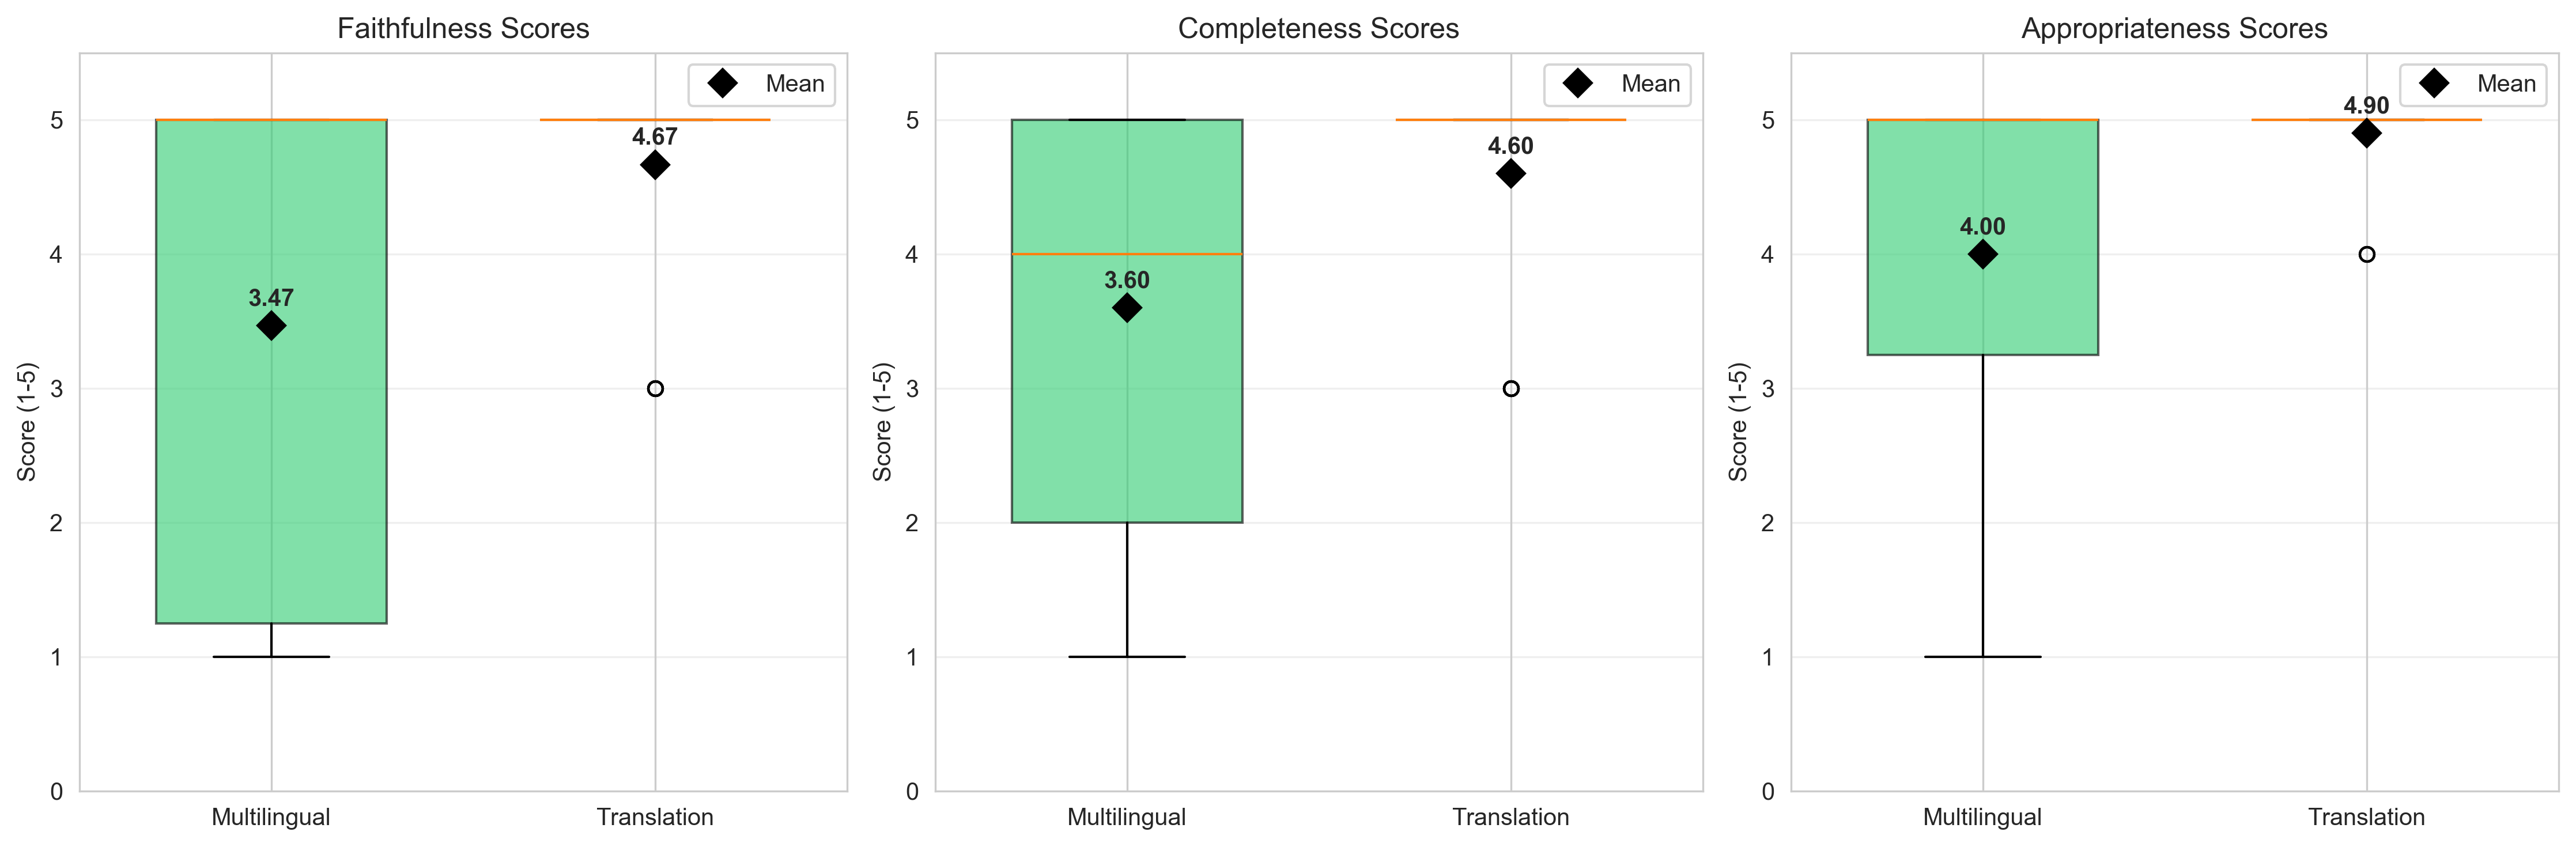

✓ Saved: llm_judge_faithfulness_breakdown.png


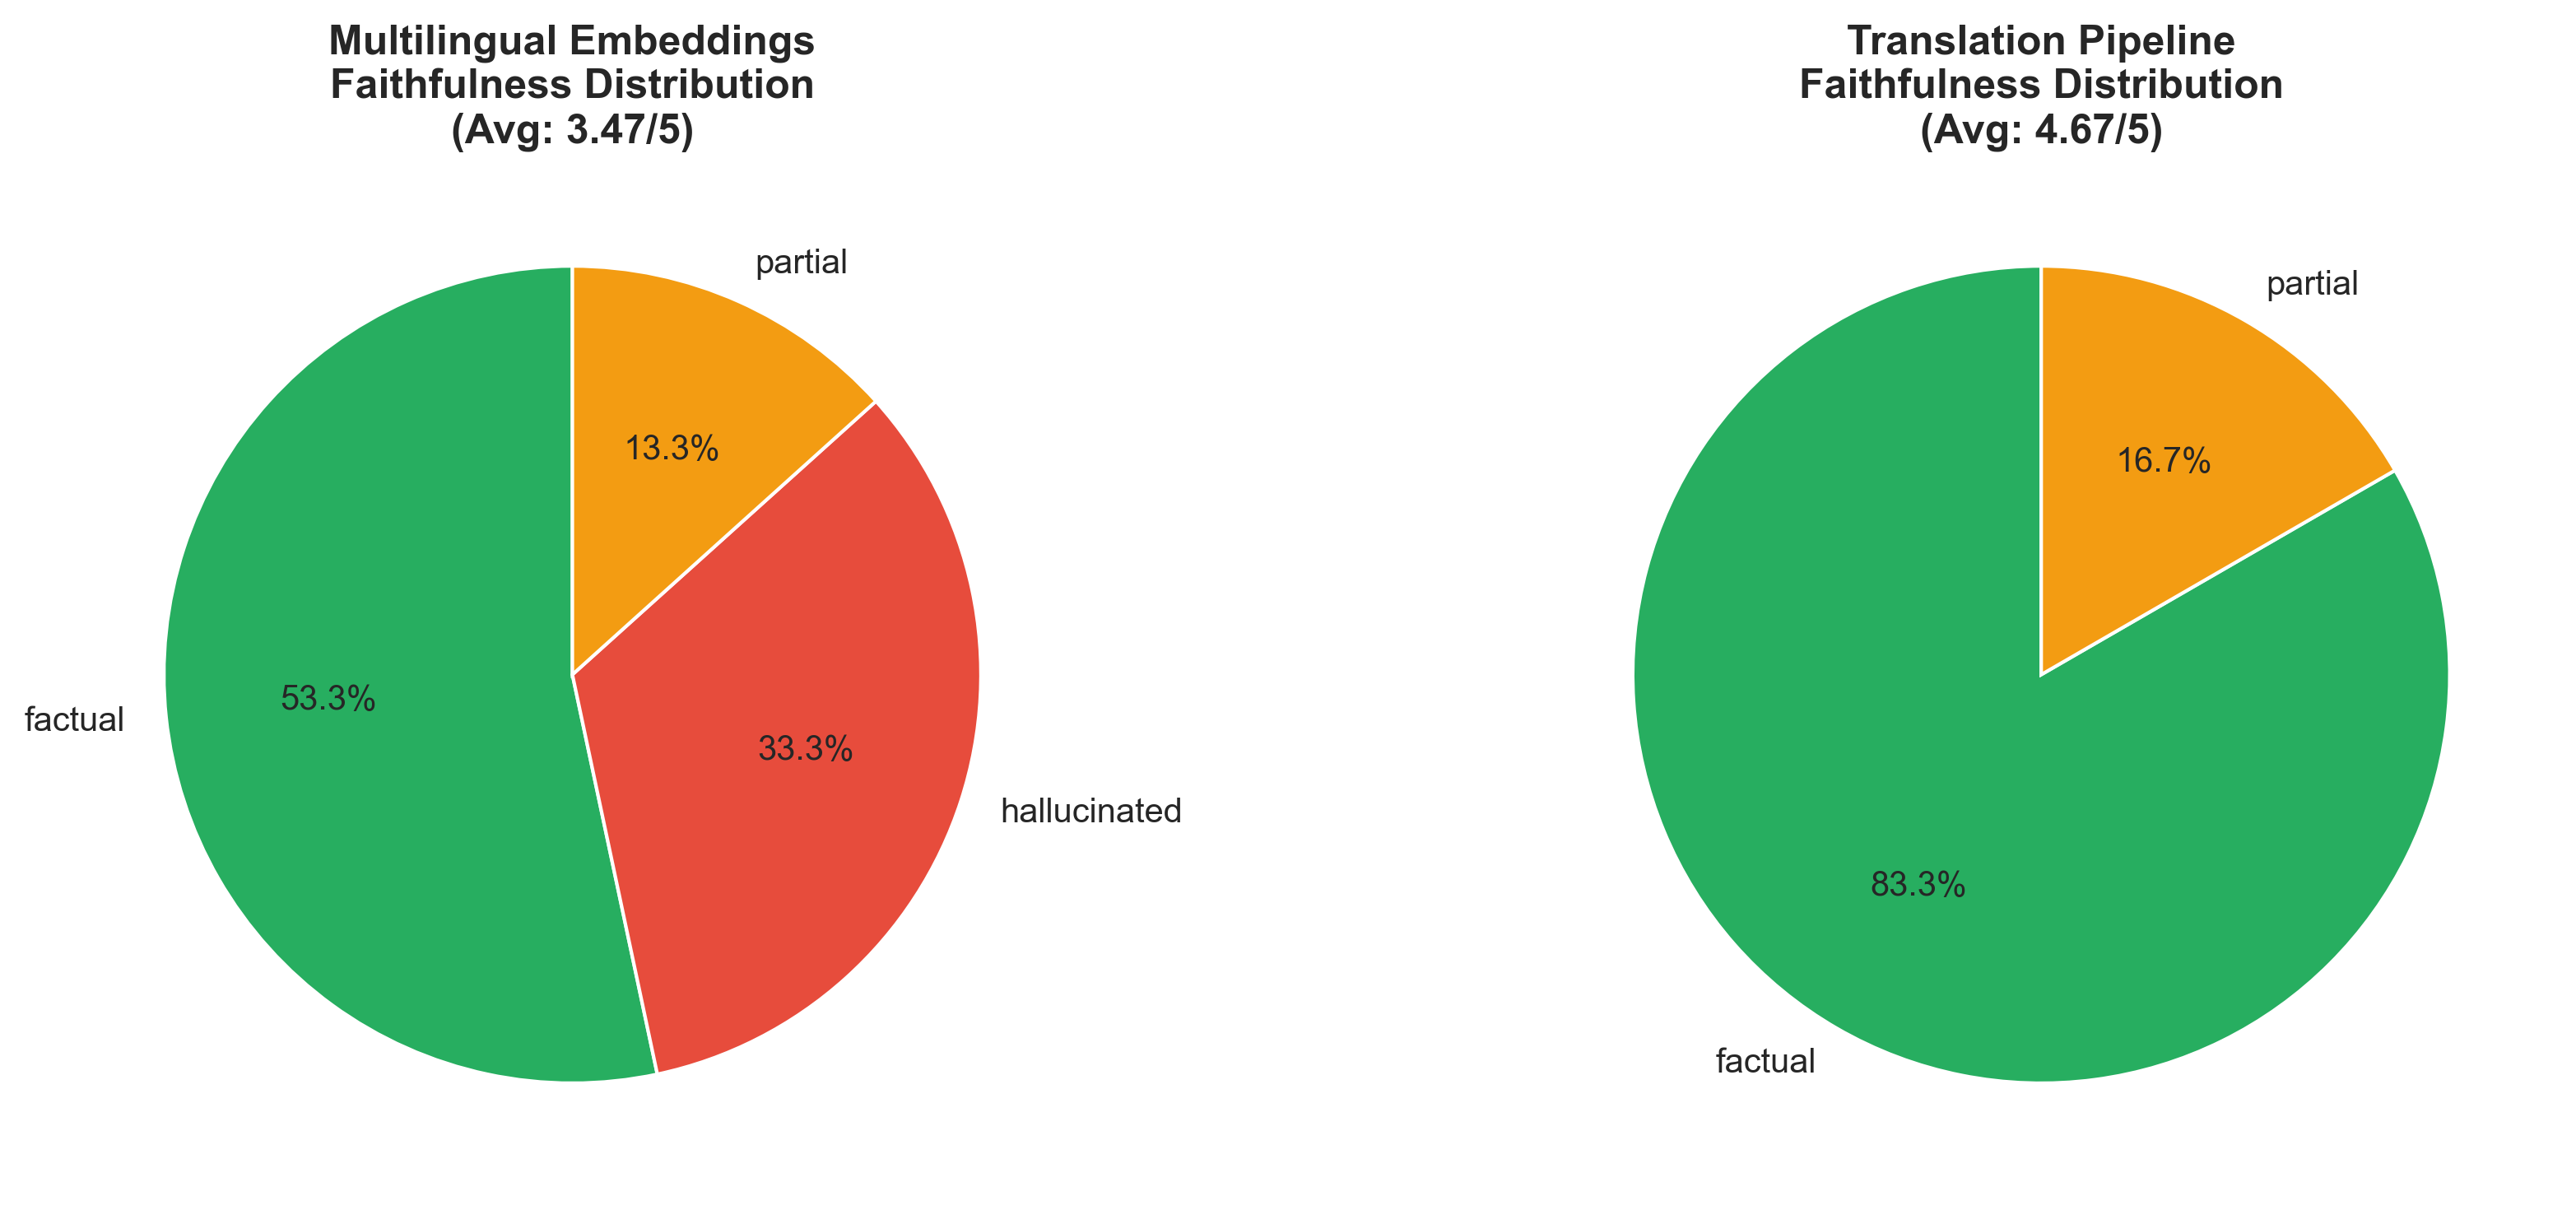

✓ Saved: llm_judge_heatmap.png


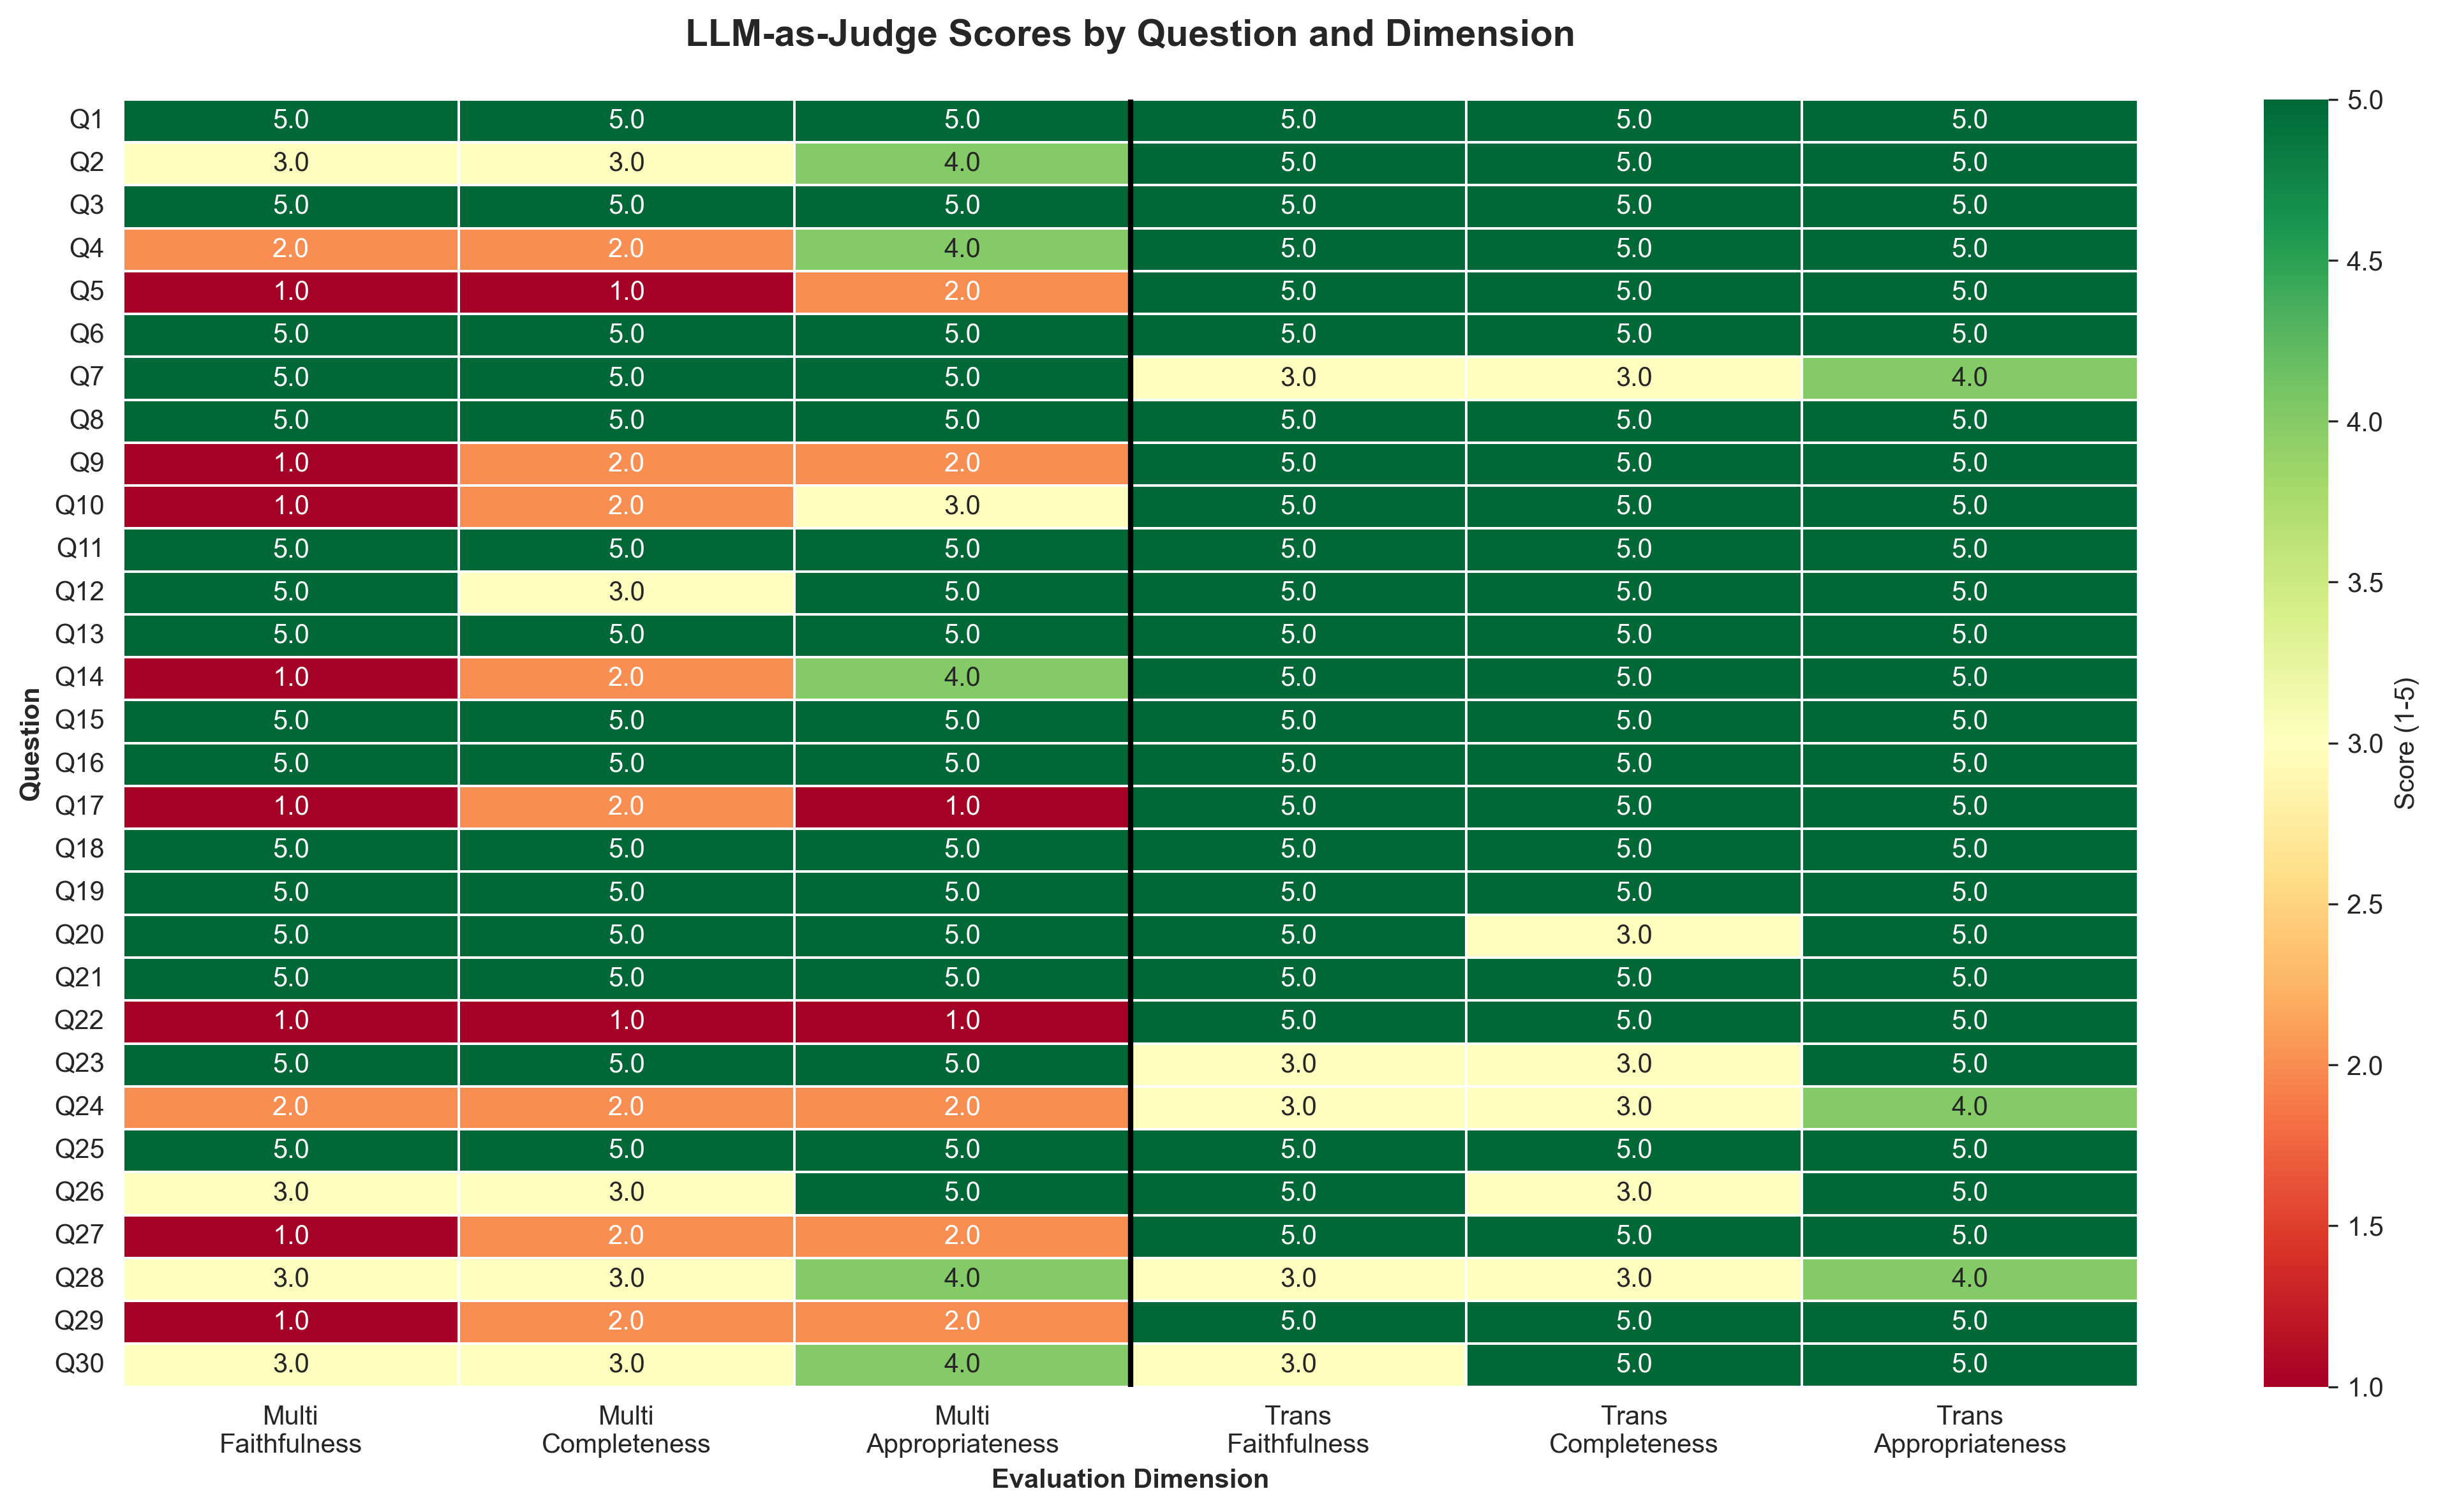

✓ Saved: llm_judge_overall_comparison.png


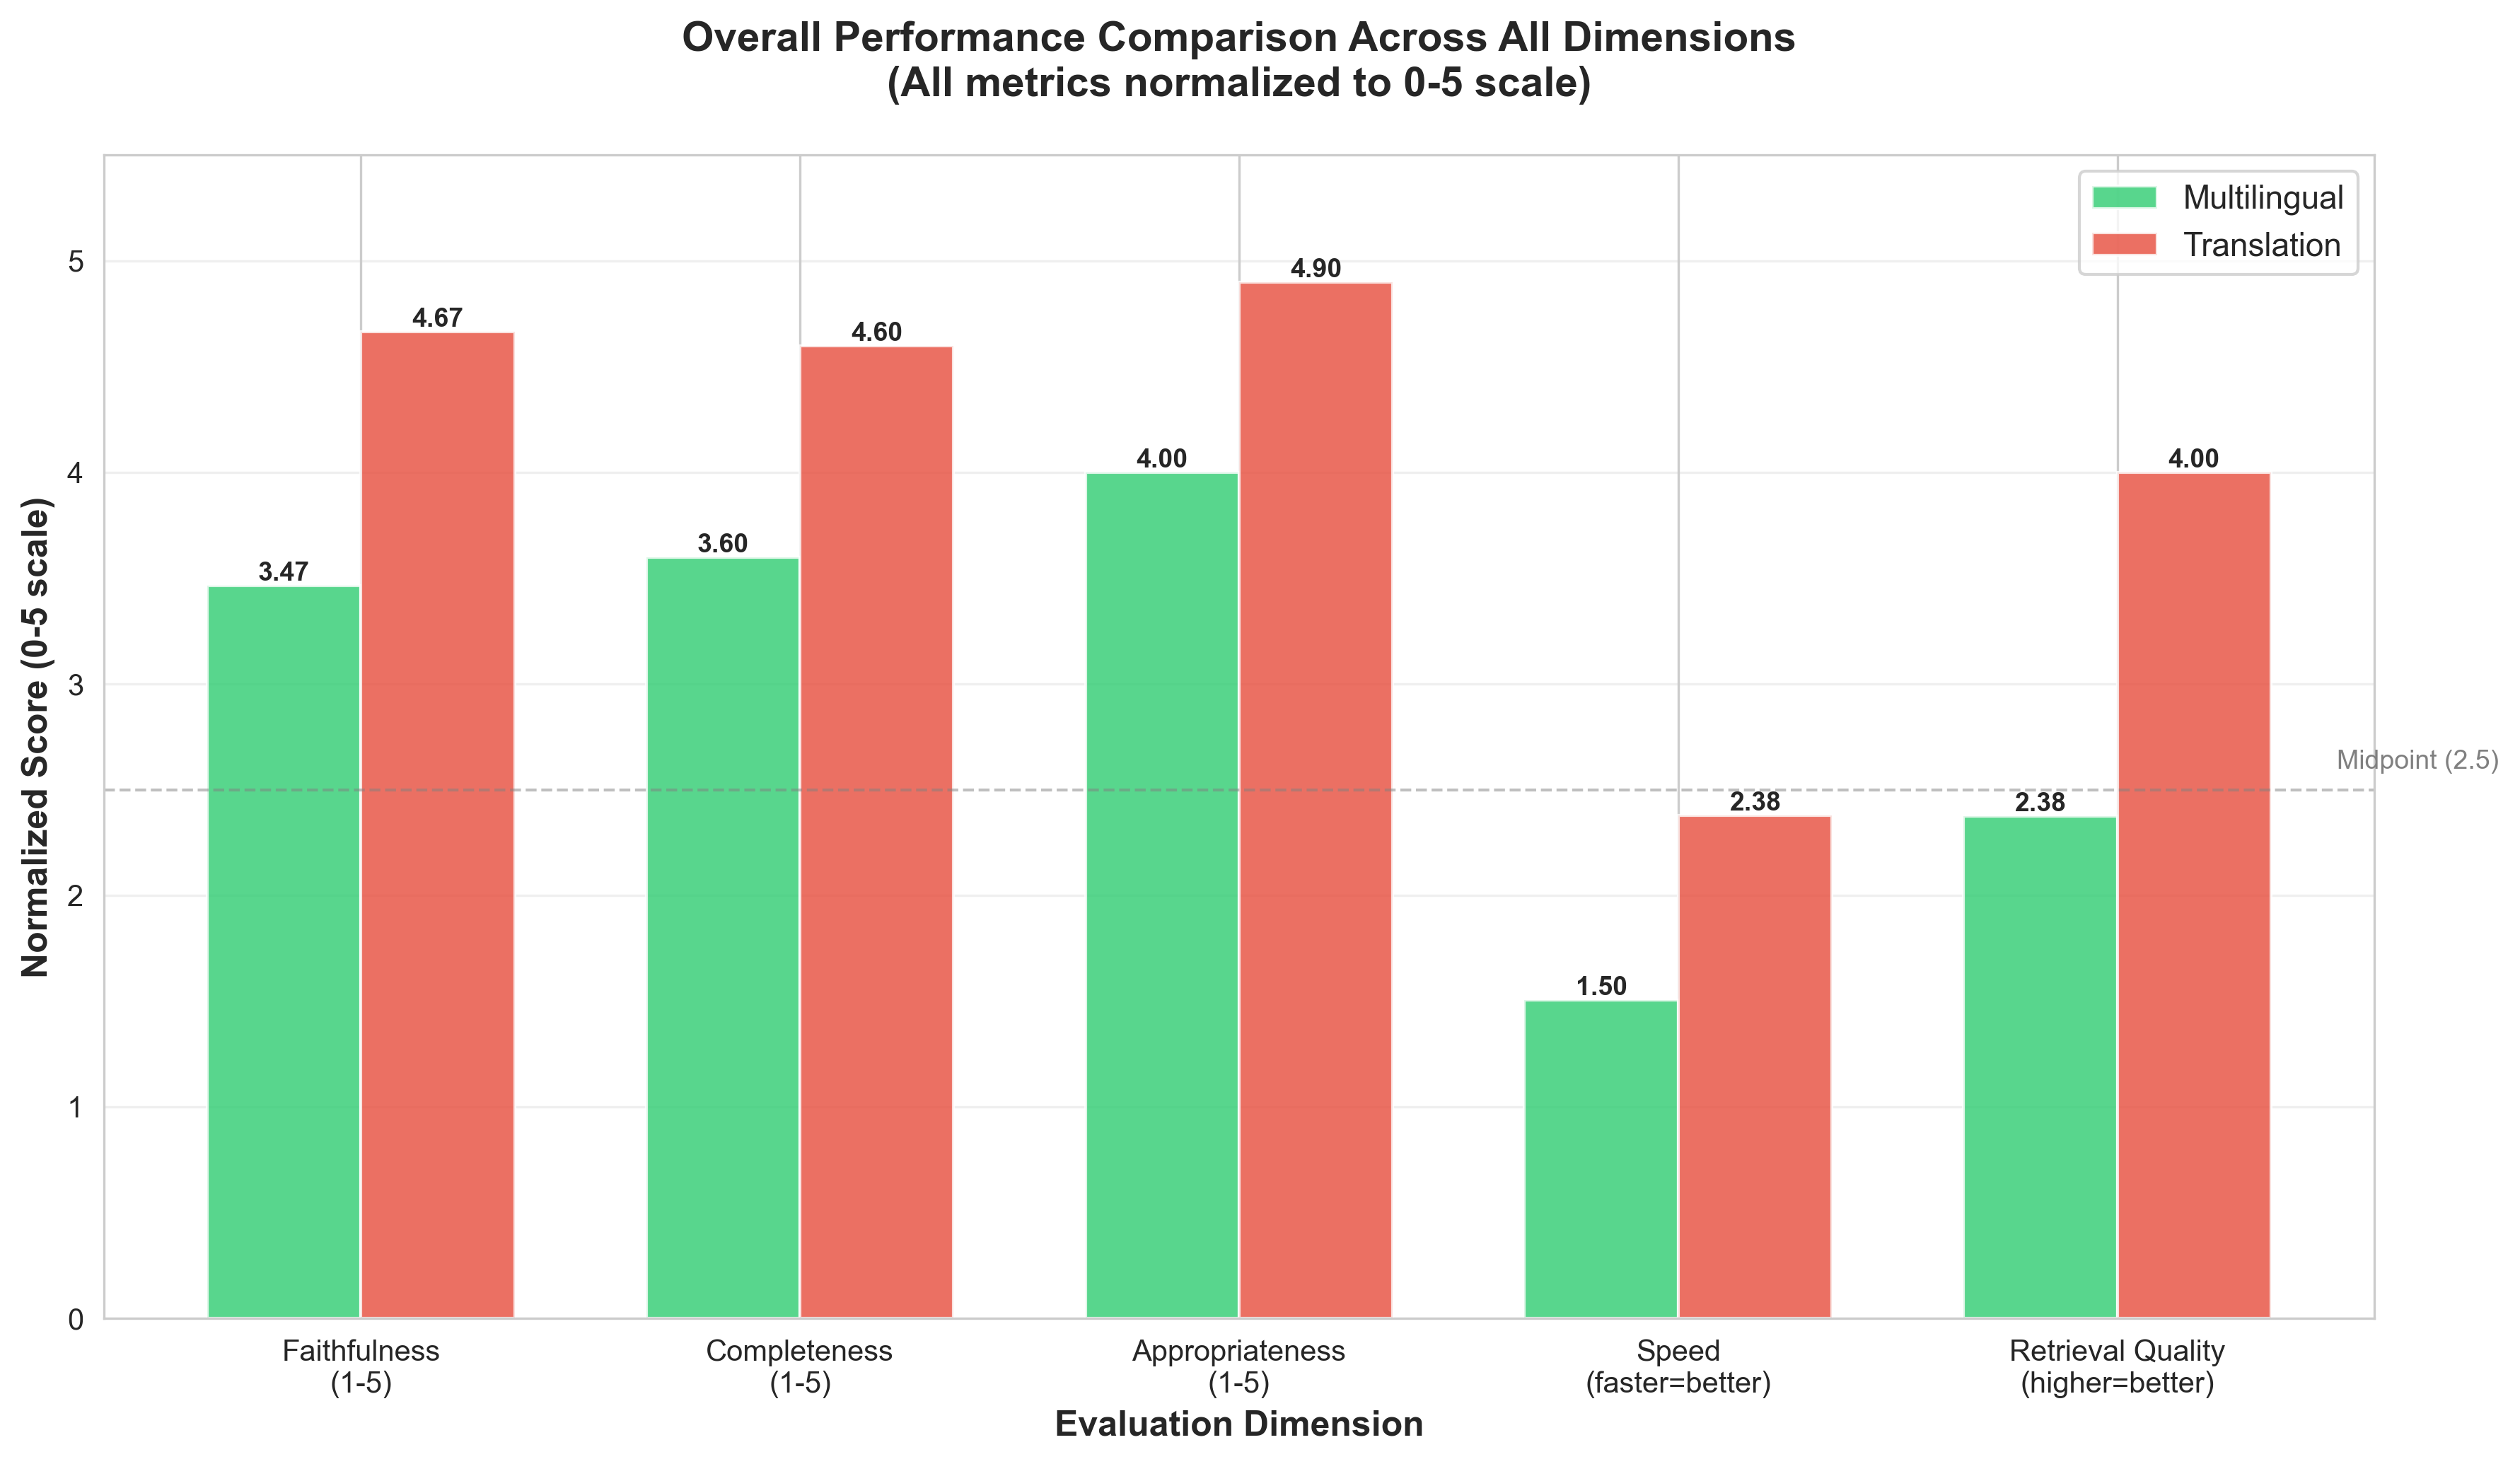


COMPREHENSIVE SUMMARY
                Metric Multilingual Translation               Winner
    Faithfulness (1-5)         3.47        4.67          Translation
    Completeness (1-5)         3.60        4.60          Translation
 Appropriateness (1-5)         4.00        4.90          Translation
 Overall Quality (1-5)         3.69        4.72          Translation
Hallucination Rate (%)        33.3%        0.0%  Translation (Lower)
 Factual Responses (%)        53.3%       83.3%          Translation
  Complete Answers (%)        13.3%       40.0%            Tied (0%)
       Speed (seconds)        6.99s       5.24s Translation (Faster)
       Retrieval Score          9.5        16.0          Translation

✓ Saved: comprehensive_summary.csv

✓ All LLM-as-Judge visualizations complete!


In [2]:
# Cell: LLM-as-Judge Visualizations
# Add this to the end of notebook 5 or create as a new cell

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# Load the LLM-as-judge results (adjust path as needed)
RESULTS_DIR = Path('../results')
llm_judge_files = list(RESULTS_DIR.glob('llm_judge_evaluation_*.csv'))
latest_llm_file = max(llm_judge_files, key=lambda x: x.stat().st_mtime)
df_llm = pd.read_csv(latest_llm_file, encoding='utf-8')

print(f"Loaded: {latest_llm_file.name}")

# ============================================================================
# Visualization 1: Score Comparison Across Dimensions
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

dimensions = [
    ('Faithfulness', 'multi_faithfulness_score', 'trans_faithfulness_score'),
    ('Completeness', 'multi_completeness_score', 'trans_completeness_score'),
    ('Appropriateness', 'multi_appropriateness_score', 'trans_appropriateness_score')
]

for idx, (title, multi_col, trans_col) in enumerate(dimensions):
    ax = axes[idx]
    
    # Box plot comparison
    data_to_plot = [df_llm[multi_col], df_llm[trans_col]]
    bp = ax.boxplot(data_to_plot, labels=['Multilingual', 'Translation'],
                    patch_artist=True, widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('#e74c3c')
    bp['boxes'][1].set_alpha(0.6)
    
    # Add mean markers
    means = [df_llm[multi_col].mean(), df_llm[trans_col].mean()]
    ax.plot([1, 2], means, 'D', color='black', markersize=8, label='Mean', zorder=3)
    
    # Annotate means
    for i, mean in enumerate(means, 1):
        ax.text(i, mean + 0.15, f'{mean:.2f}', ha='center', fontweight='bold')
    
    ax.set_ylabel('Score (1-5)')
    ax.set_title(f'{title} Scores')
    ax.set_ylim([0, 5.5])
    ax.grid(axis='y', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'llm_judge_scores_comparison.png', 
            dpi=300, bbox_inches='tight')
print("✓ Saved: llm_judge_scores_comparison.png")
plt.show()

# ============================================================================
# Visualization 2: Hallucination vs Factual Breakdown
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count labels for each approach
multi_labels = df_llm['multi_faithfulness_label'].value_counts()
trans_labels = df_llm['trans_faithfulness_label'].value_counts()

# Multilingual pie chart
ax1 = axes[0]
colors = {'factual': '#27ae60', 'partial': '#f39c12', 'hallucinated': '#e74c3c'}
multi_colors = [colors.get(label, '#95a5a6') for label in multi_labels.index]

wedges1, texts1, autotexts1 = ax1.pie(
    multi_labels.values, 
    labels=multi_labels.index,
    colors=multi_colors,
    autopct='%1.1f%%',
    startangle=90
)
ax1.set_title(f'Multilingual Embeddings\nFaithfulness Distribution\n(Avg: {df_llm["multi_faithfulness_score"].mean():.2f}/5)', 
              fontweight='bold')

# Translation pie chart
ax2 = axes[1]
trans_colors = [colors.get(label, '#95a5a6') for label in trans_labels.index]

wedges2, texts2, autotexts2 = ax2.pie(
    trans_labels.values,
    labels=trans_labels.index,
    colors=trans_colors,
    autopct='%1.1f%%',
    startangle=90
)
ax2.set_title(f'Translation Pipeline\nFaithfulness Distribution\n(Avg: {df_llm["trans_faithfulness_score"].mean():.2f}/5)',
              fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'llm_judge_faithfulness_breakdown.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved: llm_judge_faithfulness_breakdown.png")
plt.show()

# ============================================================================
# Visualization 3: Per-Question Quality Heatmap
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for heatmap
heatmap_data = []
for idx, row in df_llm.iterrows():
    heatmap_data.append([
        row['multi_faithfulness_score'],
        row['multi_completeness_score'],
        row['multi_appropriateness_score'],
        row['trans_faithfulness_score'],
        row['trans_completeness_score'],
        row['trans_appropriateness_score']
    ])

heatmap_df = pd.DataFrame(
    heatmap_data,
    columns=[
        'Multi\nFaithfulness', 'Multi\nCompleteness', 'Multi\nAppropriateness',
        'Trans\nFaithfulness', 'Trans\nCompleteness', 'Trans\nAppropriateness'
    ],
    index=[f"Q{i+1}" for i in range(len(df_llm))]
)

# Create heatmap
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    vmin=1,
    vmax=5,
    cbar_kws={'label': 'Score (1-5)'},
    linewidths=0.5,
    ax=ax
)

ax.set_title('LLM-as-Judge Scores by Question and Dimension', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Evaluation Dimension', fontweight='bold')
ax.set_ylabel('Question', fontweight='bold')

# Add vertical line to separate approaches
ax.axvline(x=3, color='black', linewidth=2)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'llm_judge_heatmap.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved: llm_judge_heatmap.png")
plt.show()

# ============================================================================
# Visualization 4: Overall Performance Comparison (Bar Chart)
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

# Categories and scores
categories = ['Faithfulness\n(1-5)', 'Completeness\n(1-5)', 'Appropriateness\n(1-5)', 
              'Speed\n(faster=better)', 'Retrieval Quality\n(higher=better)']

# Calculate scores (normalize speed for visualization)
multi_scores = [
    df_llm['multi_faithfulness_score'].mean(),
    df_llm['multi_completeness_score'].mean(),
    df_llm['multi_appropriateness_score'].mean(),
    5 - (6.99 / 10 * 5),  # Speed inverted and normalized (faster = higher score)
    9.5 / 20 * 5  # Retrieval quality normalized to 0-5
]

trans_scores = [
    df_llm['trans_faithfulness_score'].mean(),
    df_llm['trans_completeness_score'].mean(),
    df_llm['trans_appropriateness_score'].mean(),
    5 - (5.24 / 10 * 5),  # Speed inverted and normalized
    16.0 / 20 * 5  # Retrieval quality normalized to 0-5
]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, multi_scores, width, label='Multilingual',
               color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x + width/2, trans_scores, width, label='Translation',
               color='#e74c3c', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

ax.set_xlabel('Evaluation Dimension', fontweight='bold', fontsize=12)
ax.set_ylabel('Normalized Score (0-5 scale)', fontweight='bold', fontsize=12)
ax.set_title('Overall Performance Comparison Across All Dimensions\n(All metrics normalized to 0-5 scale)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(fontsize=11)
ax.set_ylim([0, 5.5])
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=2.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.text(4.5, 2.6, 'Midpoint (2.5)', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'llm_judge_overall_comparison.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved: llm_judge_overall_comparison.png")
plt.show()

# ============================================================================
# Summary Statistics Table
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY")
print("="*80)

summary = pd.DataFrame({
    'Metric': [
        'Faithfulness (1-5)',
        'Completeness (1-5)',
        'Appropriateness (1-5)',
        'Overall Quality (1-5)',
        'Hallucination Rate (%)',
        'Factual Responses (%)',
        'Complete Answers (%)',
        'Speed (seconds)',
        'Retrieval Score'
    ],
    'Multilingual': [
        f"{df_llm['multi_faithfulness_score'].mean():.2f}",
        f"{df_llm['multi_completeness_score'].mean():.2f}",
        f"{df_llm['multi_appropriateness_score'].mean():.2f}",
        f"{(df_llm['multi_faithfulness_score'].mean() + df_llm['multi_completeness_score'].mean() + df_llm['multi_appropriateness_score'].mean()) / 3:.2f}",
        f"{(df_llm['multi_faithfulness_label'] == 'hallucinated').sum() / len(df_llm) * 100:.1f}%",
        f"{(df_llm['multi_faithfulness_label'] == 'factual').sum() / len(df_llm) * 100:.1f}%",
        f"{(df_llm['multi_completeness_label'] == 'complete').sum() / len(df_llm) * 100:.1f}%",
        "6.99s",
        "9.5"
    ],
    'Translation': [
        f"{df_llm['trans_faithfulness_score'].mean():.2f}",
        f"{df_llm['trans_completeness_score'].mean():.2f}",
        f"{df_llm['trans_appropriateness_score'].mean():.2f}",
        f"{(df_llm['trans_faithfulness_score'].mean() + df_llm['trans_completeness_score'].mean() + df_llm['trans_appropriateness_score'].mean()) / 3:.2f}",
        f"{(df_llm['trans_faithfulness_label'] == 'hallucinated').sum() / len(df_llm) * 100:.1f}%",
        f"{(df_llm['trans_faithfulness_label'] == 'factual').sum() / len(df_llm) * 100:.1f}%",
        f"{(df_llm['trans_completeness_label'] == 'complete').sum() / len(df_llm) * 100:.1f}%",
        "5.24s",
        "16.0"
    ],
    'Winner': [
        'Translation' if df_llm['trans_faithfulness_score'].mean() > df_llm['multi_faithfulness_score'].mean() else 'Multilingual',
        'Translation' if df_llm['trans_completeness_score'].mean() > df_llm['multi_completeness_score'].mean() else 'Multilingual',
        'Translation' if df_llm['trans_appropriateness_score'].mean() > df_llm['multi_appropriateness_score'].mean() else 'Multilingual',
        'Translation',
        'Translation (Lower)',
        'Translation',
        'Tied (0%)',
        'Translation (Faster)',
        'Translation'
    ]
})

print(summary.to_string(index=False))
print("="*80)

# Save comprehensive summary
summary.to_csv(RESULTS_DIR / 'figures' / 'comprehensive_summary.csv', index=False)
print("\n✓ Saved: comprehensive_summary.csv")
print("\n✓ All LLM-as-Judge visualizations complete!")